In [1]:
import os
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import copy
import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional

from preproc import import_csv

In [2]:
def dist_plot(series: pd.core.series.Series, dropna: bool = True, sig: Optional[int] = None) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    sig = sig or 0
    
    
    quarts = scipy.stats.mstats.mquantiles(series, [0.001, 0.25, 0.5, 0.75, 0.975])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_hist.axvline(series.mean())
    ax_hist.set_xticks(quarts)
    #ax_box.set(xlabel=f'Mean value : {int(series.mean())}')
    plt.title(f"Glycaemic Distribution μ = {round(series.mean(), sig)}, σ = {round(series.std(), sig)}")
##

def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "mean"
) -> NoReturn:
    """ 
    """
    
    glc_to_hba1c = lambda x: (x + 105) / 36.5
    hba1c_to_glc = lambda x: x*36.5 - 105 
    valid_kinds = ["mean", "std", "var", "median"]
    
    if kind in valid_kinds:
        df.groupby(df.index.date)[colum_name].\
            apply(eval(f"pd.Series.{kind}")).apply(hba1c).\
                plot(**{"label":"daily"})
                
        for key, value in windows.items():
            ax = df.groupby(df.index.date)[colum_name].\
                    apply(eval(f"pd.Series.{kind}")).rolling(value).mean().\
                            apply(hba1c).plot(**{"label":key})
    
        ax.set_ylabel("HbA1c %")
        mean_hba1c = glc_to_hba1c(eval(f"df[colum_name].{kind}()"))
        secax = ax.secondary_yaxis('right', functions=(hba1c_to_glc, glc_to_hba1c))
        secax.set_ylabel('mg/dL')
        plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
        plt.legend()
        plt.title(f"Average {kind} of {colum_name}")
    else:
        raise Exception(f"kind should be one of {valid_kinds}")
##

def proportions_visualiser(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    limits: Dict[str,int] = {
        "low": 70,
        "high": 180
    },
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "TIR"
) -> NoReturn:
    """
        Wuhuuuu
    """
    
    valid_kinds = ["TIR", "TBR", "TAR"]
    titles = {
        "TIR": f"Time In Range [{limits['low']},{limits['high']})",
        "TAR": f"Time Above Range >= {limits['high']}",
        "TBR": f"Time Below Range < {limits['low']}"
    }
    
    kind = kind.upper()
    
    if kind not in valid_kinds:
        raise Exception(f"Invalid kind `{kind}`, select one from {valid_kinds}")
    
    TIR = lambda y: 100 * y[ (y >= limits["low"]) & (y < limits["high"]) ].count() / y.count()
    TBR = lambda y: 100 * y[ (y < limits["low"]) ].count() / y.count()
    TAR = lambda y: 100 * y[ (y >= limits["high"]) ].count() / y.count()
    
    _proportions = df["Sensor Glucose (mg/dL)"].groupby(data.index.date).apply(eval(f"{kind}"))
    
    _proportions.plot(**{"label": "daily"})
    
    for key, value in windows.items():
        _ax = _proportions.rolling(value).mean().plot(**{"label":key})
    
    _mean_proportion = _proportions.mean()
    plt.ylabel("Percentage")
    plt.axhline(_mean_proportion, **{"label": f"mean = {round(_mean_proportion,1)}", "c": "blue"})
    plt.legend()
    plt.title(titles[kind])
##    

def nonull_indices(
    df: pd.DataFrame,
    column: str
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """  
    _nonull = df[column].dropna()
    _nonull = _nonull[ _nonull > 0 ]
    return _nonull.index
##

def bolus_indices(
    df: pd.DataFrame, 
    columns: Optional[List[str]] = None
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """
    
    columns = columns or ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    _nonull = partial(nonull_indices, df)
    indices_ls = list(map(_nonull, columns))
    return reduce(lambda x, y: x.union(y), indices_ls)
##


def basal_only(df: pd.DataFrame, column: str = "Sensor Glucose (mg/dL)") -> pd.DataFrame:
    """
    """
    basal = df.copy()
    for uid in bolus_indices(basal):
        real = uid+dt.timedelta(hours=2, minutes=30)
        closest = df.index[df.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
        basal.loc[uid:closest, column] = np.nan
    return basal
##

def hourly_trends(df: pd.DataFrame, kind: str = "mean", deltas: Optional[List[int]] = None) -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var", "median"]
    deltas = deltas or [15, 30, 60, 120]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}'].
                apply(eval(f"np.{kind}")).
                    plot(label=f"{i} ") 
            for i in deltas
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##        

In [3]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [19]:
data = import_csv("interpolated/NG1988812H_Maganna_Gustavo_(8-03-20)_(30-05-20)_interpolated.csv")

/home/gml/.cache/pypoetry/virtualenvs/diabetes-analysis-lNCkfS_0-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,6,7,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [20]:
#data.columns

In [21]:
#help(pd.DataFrame.to_csv)

In [22]:
print("start \t:", data.index[0])
print("end \t:", data.index[-1])

start 	: 2020-01-20 04:52:00
end 	: 2020-05-30 22:27:00


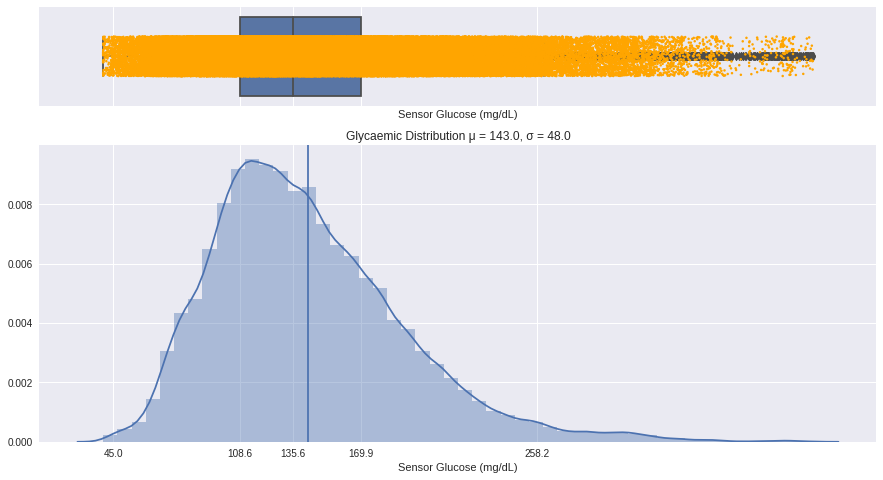

In [23]:
dist_plot(data["Sensor Glucose (mg/dL)"])

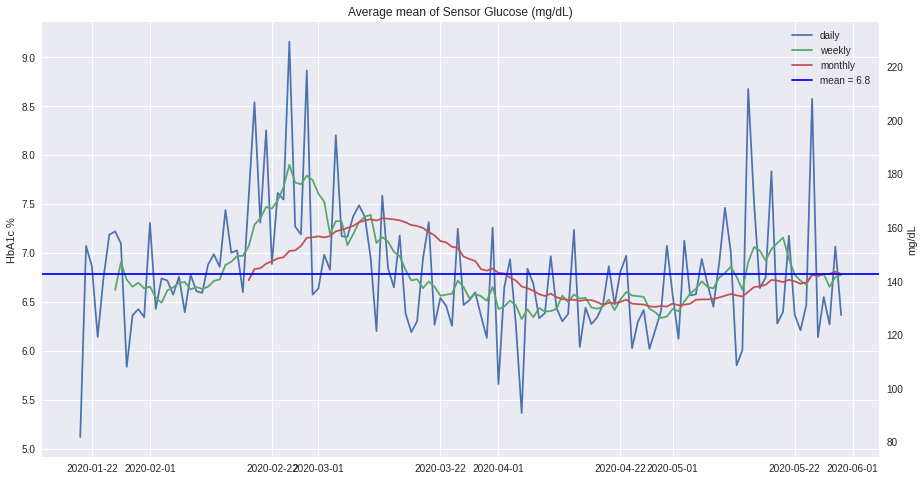

In [24]:
comparative_hba1c_plot(data, kind="mean")

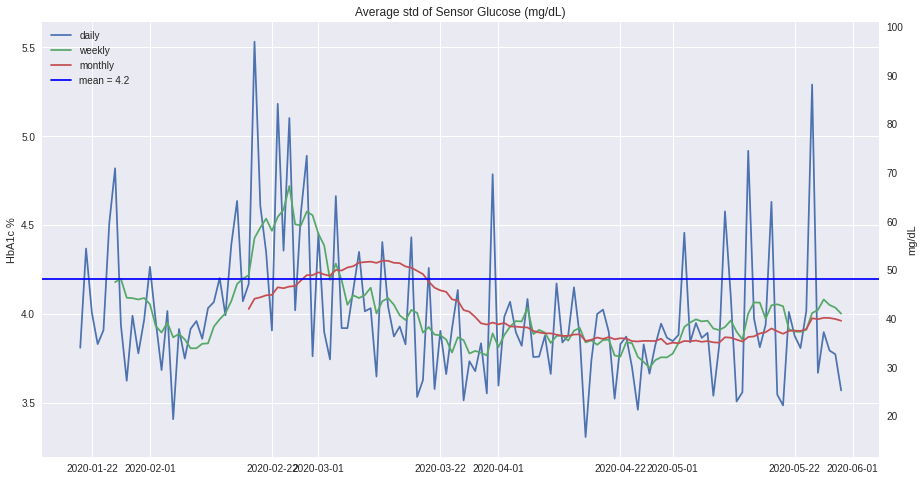

In [25]:
comparative_hba1c_plot(data, kind='std')

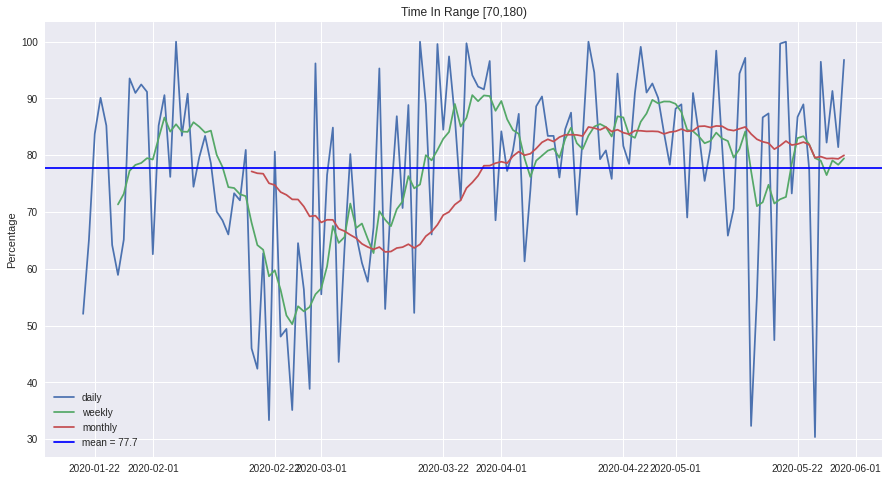

In [26]:
proportions_visualiser(data, kind="tir")

In [27]:
dates = pd.unique(data.index.date)
n_total = len(dates)
print(f"Number of days in data : {len(dates)}")

Number of days in data : 132


In [28]:
n_month = 30
n_latest = 4
month = data.loc[dates[len(dates) - n_month]:dates[-1], :] if n_month < n_total else None
latest = data.loc[dates[len(dates)- n_latest]:dates[-1], :] if n_latest < n_total else None

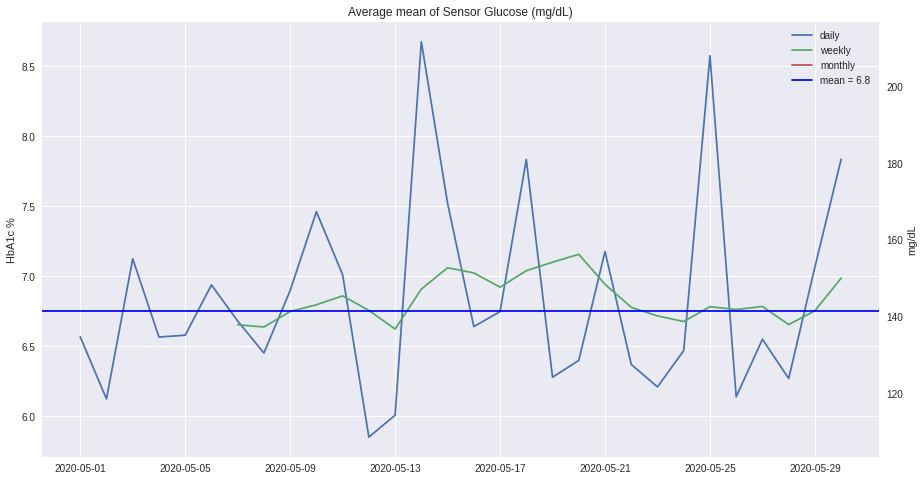

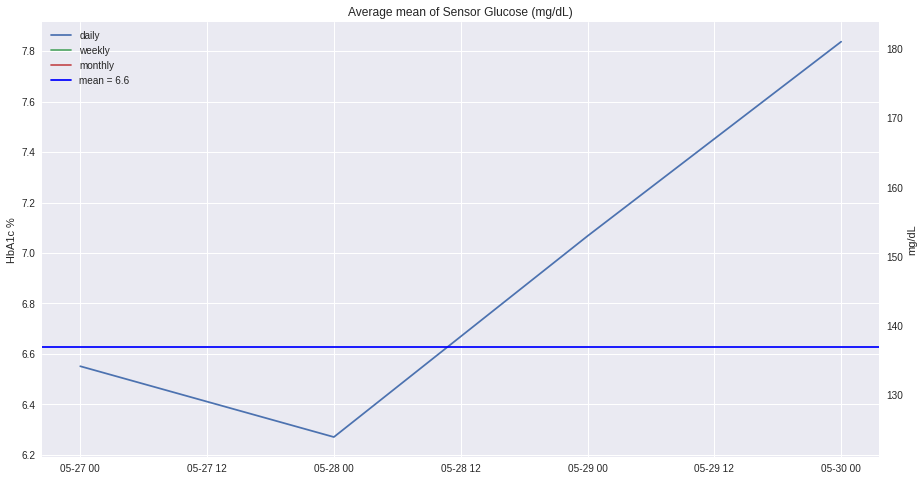

In [29]:
comparative_hba1c_plot(month)
plt.figure()
comparative_hba1c_plot(latest)

In [30]:
# maybe we should interpolate grouping by day ?

In [31]:
#latest.loc["2020-04-15", "Sensor Glucose (mg/dL)"].interpolate().plot()
#latest.loc["2020-04-15", "Sensor Glucose (mg/dL)"].plot()
latest.columns

Index(['New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'Preset Bol

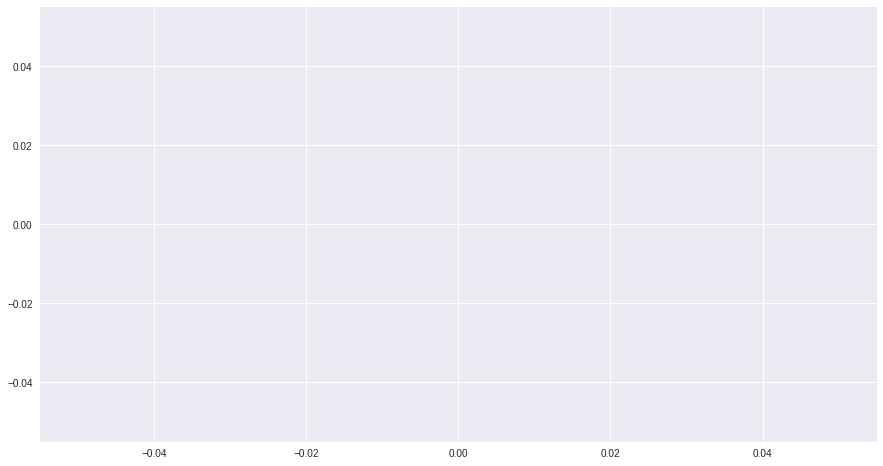

In [32]:
sns.scatterplot(
    data=latest,
    x="minutes",
    y="Sensor Glucose (mg/dL)",
    hue=latest.index.date,
    size="d30"
)

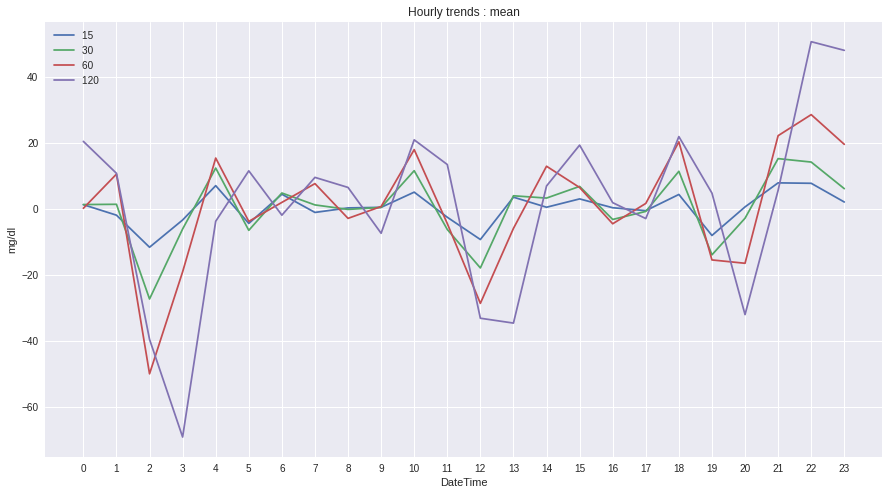

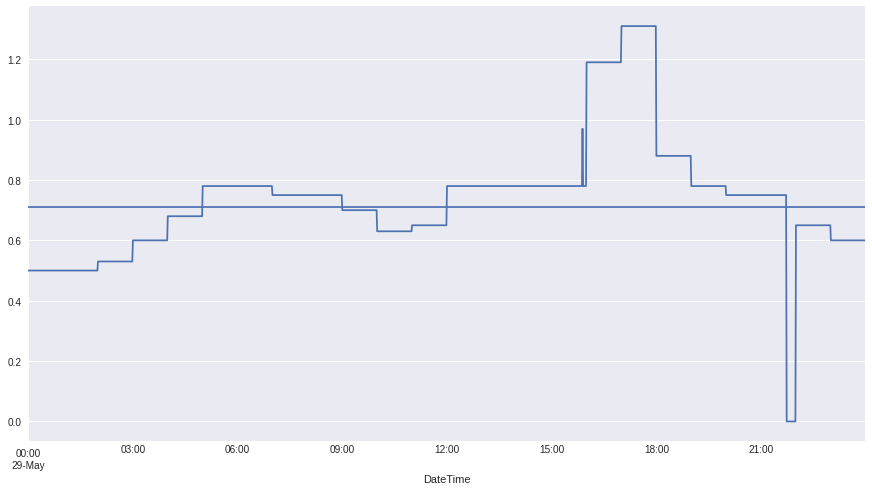

In [33]:
hourly_trends(latest, kind="mean")
plt.figure()
latest.loc["2020-05-29","Basal Rate (U/h)"].plot()
plt.axhline(latest["Basal Rate (U/h)"].mean())

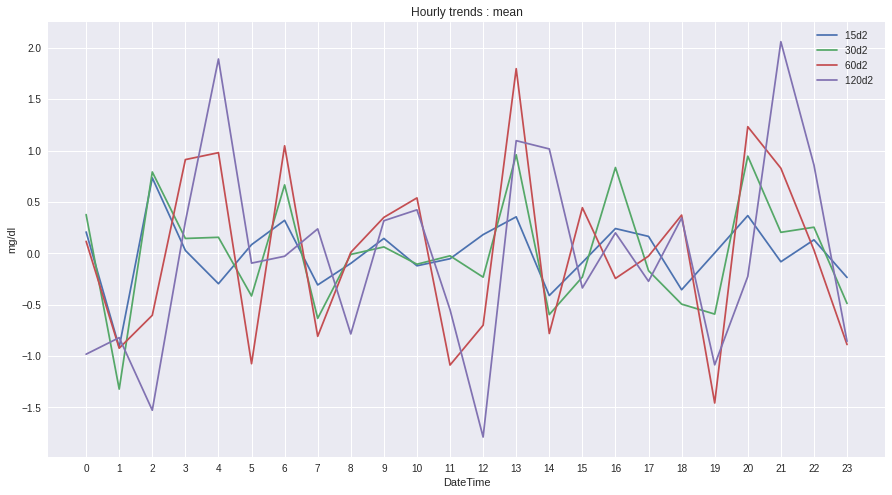

In [36]:
hourly_trends(latest, kind="mean", deltas=["15d2", "30d2", "60d2", "120d2"])

In [89]:
latest["Basal Rate (U/h)"].describe()

count    4321.000000
mean        0.710278
std         0.192548
min         0.000000
25%         0.630000
50%         0.750000
75%         0.780000
max         1.310000
Name: Basal Rate (U/h), dtype: float64

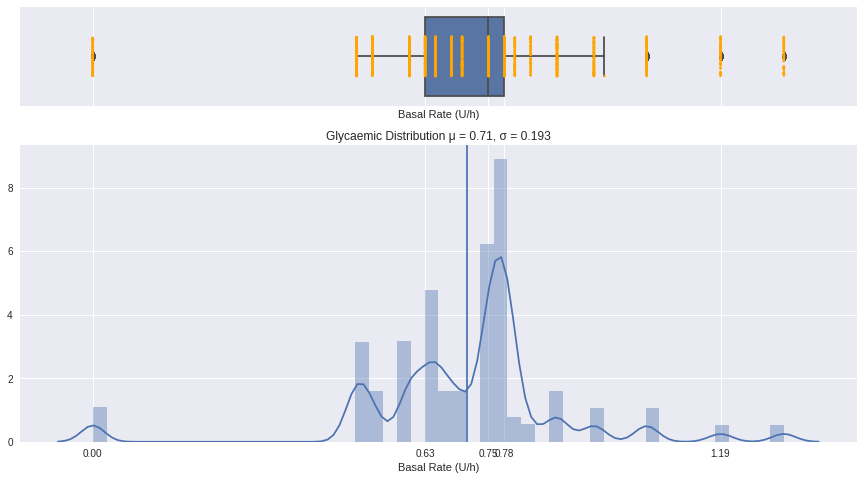

In [94]:
dist_plot(latest["Basal Rate (U/h)"], sig=3)

In [40]:
#hourly_trends(basal, kind="std")

In [79]:
basal = basal_only(latest)

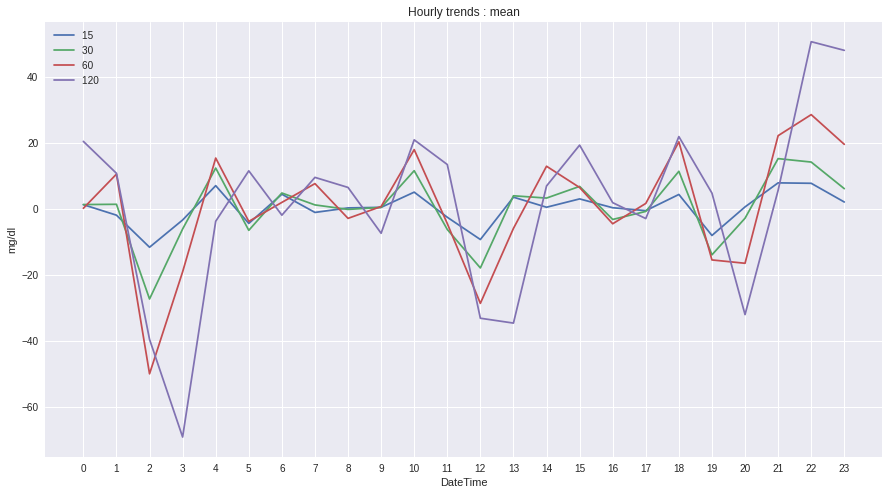

In [80]:
hourly_trends(basal)

In [81]:
#hourly_trends(basal, kind="std")

In [82]:
bar = nonull_indices(latest, "BWZ Carb Input (grams)")

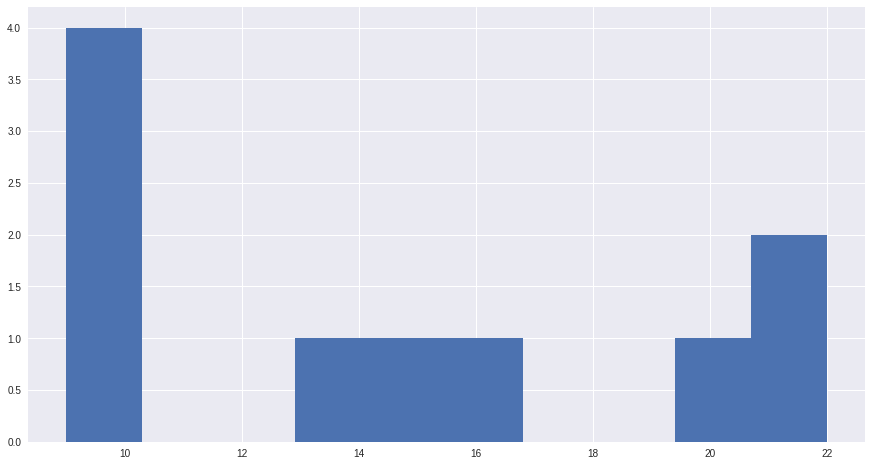

In [83]:
bar.hour.to_series().hist()

In [84]:
foo = nonull_indices(latest, "BWZ Correction Estimate (U)")

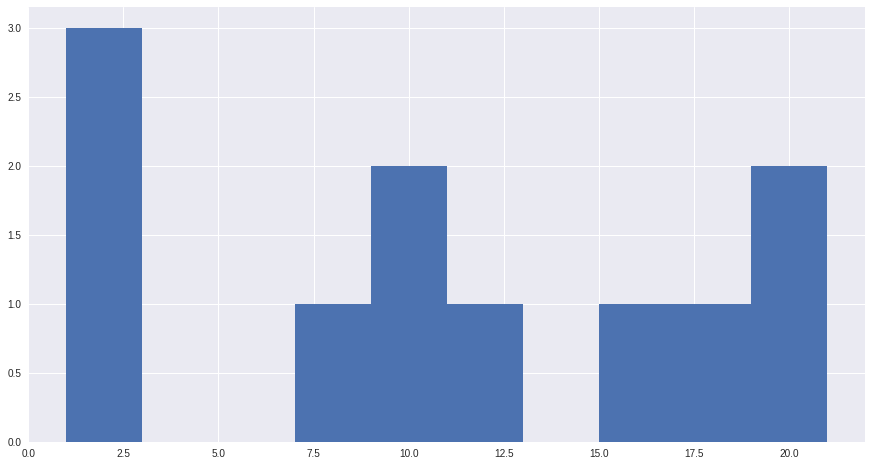

In [85]:
foo.hour.to_series().hist()